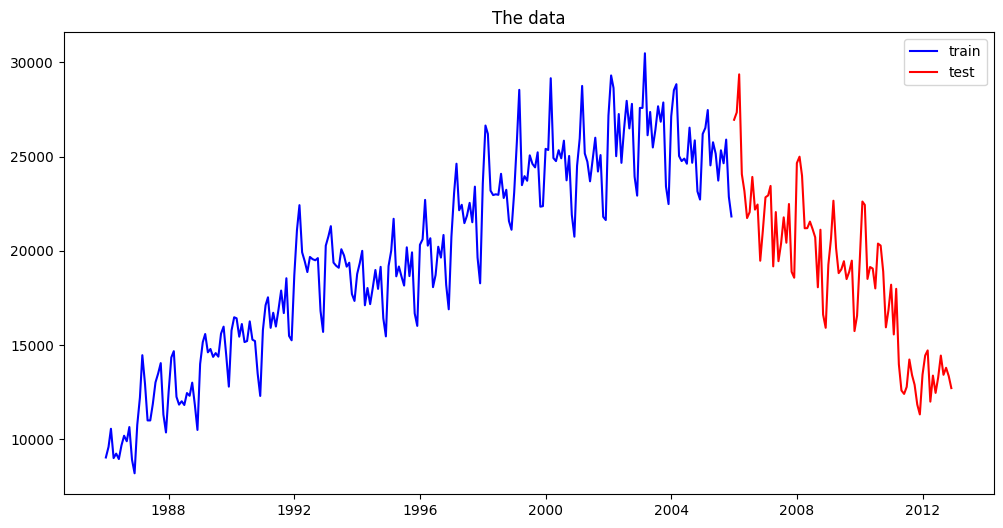

'\n1- replace the ARIMA with -Seasonal ARIMA- expecting better results\n2- \n'

In [ ]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import pandas as pd
import statsmodels.api as sm


df = pd.read_csv('/content/CATFISH.csv')
df['Date'] = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)

train = df[:240]
test = df[240:]

fig = plt.figure(figsize = (12,6))
plt.plot(train, color = 'blue', label = "train")
plt.plot(test, color = 'red', label = "test")
plt.title("The data")
plt.legend()
plt.show()

'''
1- replace the ARIMA with -Seasonal ARIMA- expecting better results
'''

In [ ]:
Arima_parameters = (20,1,19) # we statistically calculated it in the ARIMA notebook
xGboost_parameters = [{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 100,
 'reg_alpha': 0.001,
 'subsample': 0.6} ,100]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

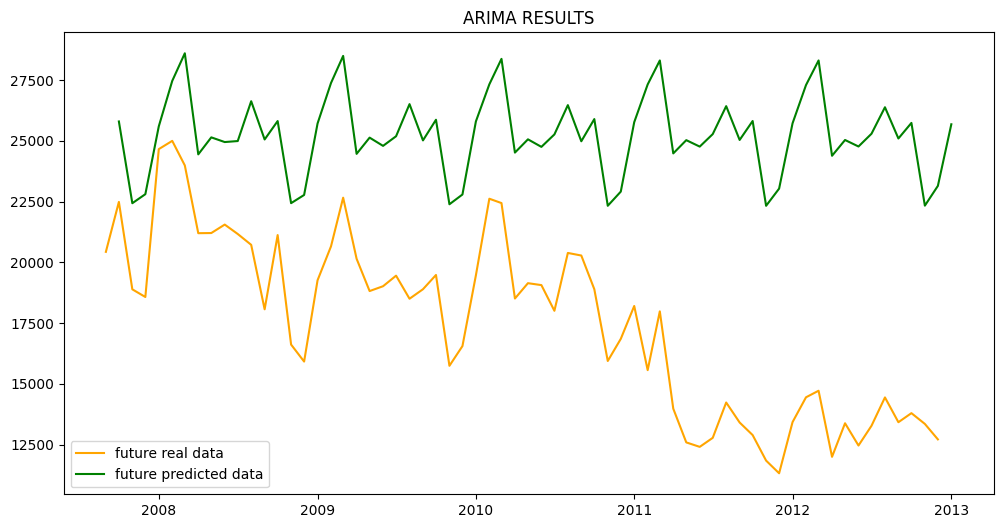

model AIC : 3659.6657279384945
model BIC : 3795.2285971311544
[18:44:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:21595.10148
[1]	validation-rmse:19502.57986
[2]	validation-rmse:17681.46095
[3]	validation-rmse:15966.41143
[4]	validation-rmse:14413.76759
[5]	validation-rmse:12892.61755
[6]	validation-rmse:11680.44974
[7]	validation-rmse:10518.30474
[8]	validation-rmse:9457.96772
[9]	validation-rmse:8439.92714
[10]	validation-rmse:7619.13056
[11]	validation-rmse:6788.86136
[12]	validation-rmse:6141.13710
[13]	validation-rmse:5509.90975
[14]	validation-rmse:4919.48414
[15]	validation-rmse:4419.62070
[16]	validation-rmse:4052.97028
[17]	validation-rmse:3670.98236
[18]	validation-rmse:3344.29655
[19]	validation-rmse:3031.29215
[20]	validation-rmse:2755.17004
[21]	validation-rmse:2552.10713
[22]	validation-rmse:2378.10555
[23]	validation-rmse:2230.09184
[24]	validation-rmse:2089.83310
[25]	validation-rmse:1967.16555
[26]	validation-rm

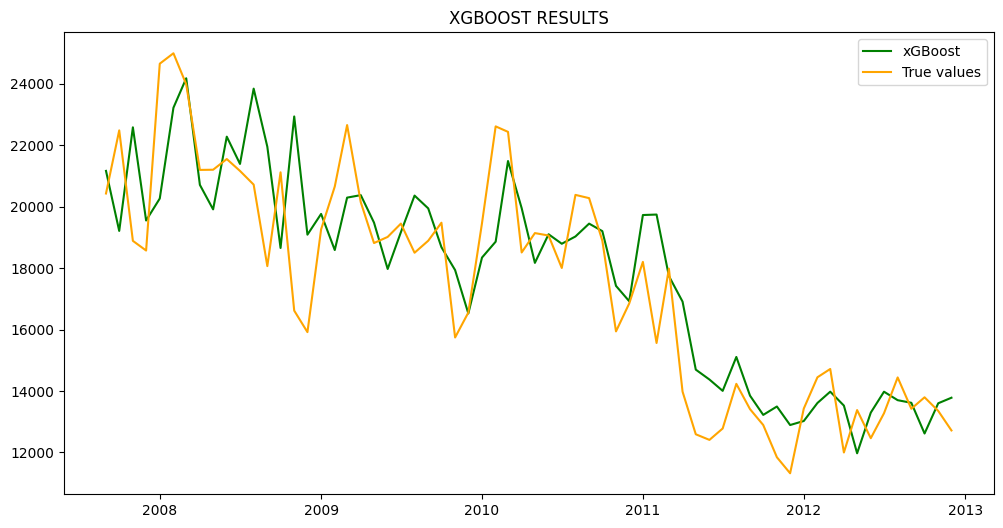

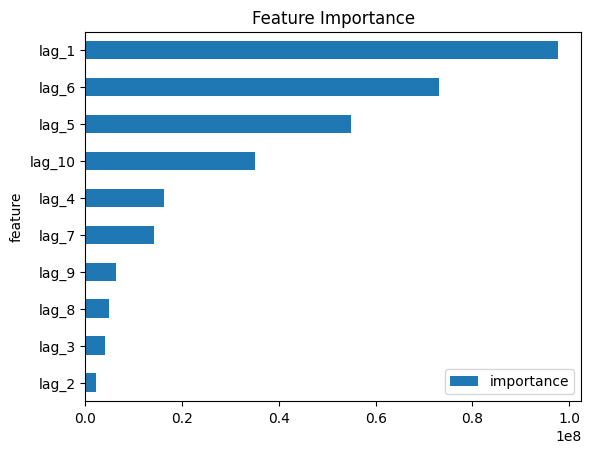

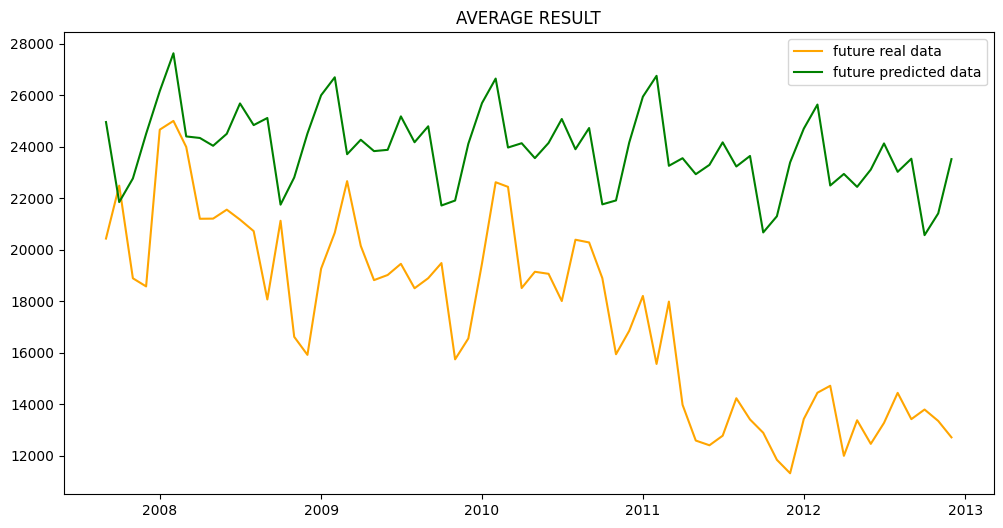

{'ARIMA': 8575.862355485093, 'XGBOOST': 1907.849518684049, 'AVERAGE RESULTS': 7132.729145121074}


In [ ]:
rmse_dict = {}
forcast_dict = {}

"""
RUN IF YOU WANT 2008 - > :  (Test)
parameters :
data: Pandas dataframe of a single series with index of type DateTime
Arima_parameters: Tuple -or list like- of shape (3) with P,Q,D
xGboost_parameters: a list of 2 items
  - the fist is a dictionary with the parameters
  - the second is the number of iterations
"""


data_original = df
Arima_parameters = Arima_parameters
xGboost_parameters = xGboost_parameters

# part 1 | ARIMA
data_A = data_original.copy()
# split the data
train = data_A[:220]
validation = data_A[220:260]
test = data_A[260:]

# build the model
model = ARIMA(train, order = Arima_parameters)
model_fit = model.fit()


# evaluate the ARIMA model in the test set
forecast_df = model_fit.predict(start = 261, end = df.shape[0] )
forecast = np.array(forecast_df)
forcast_dict['ARIMA'] = forecast
rmse = sqrt(mean_squared_error(test, forecast))
rmse_dict['ARIMA'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
'''
plt.fill_between(
  test.index,
  conf[:,0],
  conf[:,1],
  forecast['Upper'],
  alpha=0.7,
  color='gray',
  label='Confidence Area'
  )
'''
plt.plot(forecast_df, color = 'green', label = "future predicted data")
plt.title("ARIMA RESULTS")
plt.legend()
plt.show()
print(f'model AIC : {model_fit.aic}')
print(f'model BIC : {model_fit.bic}')

# part 2 | xGboost
data = data_original.copy()
# Create multible features (lagged variables)
lags = 10
for i in range(1, lags + 1):
    data[f'lag_{i}'] = data['Total'].shift(i)

# Prepare the data for XGBoost
# split the data into (train, validate, test)

X_train = data[:220].drop(['Total'], axis=1)
y_train = data[:220]['Total']

X_val = data[220:260].drop(['Total'], axis=1)
y_val = data[220:260]['Total']

X_test = data[260:].drop(['Total'], axis=1)
y_test = data[260:]['Total']

# put the data into a form of a matrix that fits into xGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = xGboost_parameters[0]
num_rounds = xGboost_parameters[1]

model = xgb.train(
  params=params,
  dtrain = dtrain,
  num_boost_round=num_rounds,
  early_stopping_rounds=10,
  evals=[(dval, 'validation')]
)

# Evaluate the XGBoost model on the test set
y_pred = model.predict(dtest)
forcast_dict['XGBOOST'] = y_pred
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse_dict['XGBOOST'] = rmse

# plot the results
fig = plt.figure(figsize = (12,6))
plt.plot(data[260:].index,y_pred, color = 'green', label = 'xGBoost')
plt.plot(data[260:].index,y_test.values, color = 'orange', label = 'True values')
plt.title("XGBOOST RESULTS")
plt.legend()
plt.plot()

#importance of features in XGBOOST
importance = model.get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
fi = pd.DataFrame(importance, columns=['feature', 'importance'])
fi.sort_values('importance').plot(kind='barh', x='feature', y='importance', title='Feature Importance')
plt.show()


# part 3 : the average forcast
# combine the predictions using a weighted average
weights = [rmse_dict['ARIMA'] / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), rmse_dict['XGBOOST'] / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=weights)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT")
plt.legend()
plt.show()

print(rmse_dict)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

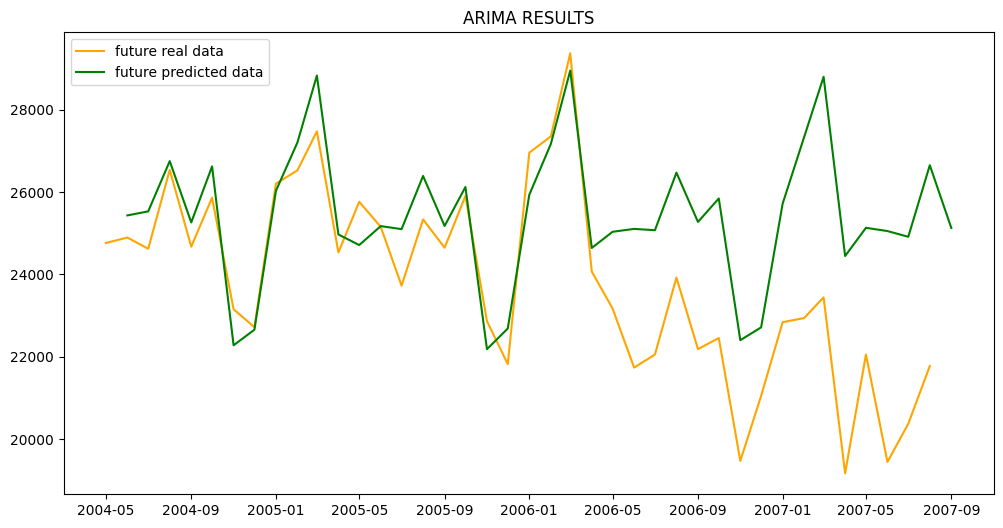

model AIC : 3659.6657279384945
model BIC : 3795.2285971311544
[17:55:49] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:21595.10148
[1]	validation-rmse:19502.57986
[2]	validation-rmse:17681.46095
[3]	validation-rmse:15966.41143
[4]	validation-rmse:14413.76759
[5]	validation-rmse:12892.61755
[6]	validation-rmse:11680.44974
[7]	validation-rmse:10518.30474
[8]	validation-rmse:9457.96772
[9]	validation-rmse:8439.92714
[10]	validation-rmse:7619.13056
[11]	validation-rmse:6788.86136
[12]	validation-rmse:6141.13710
[13]	validation-rmse:5509.90975
[14]	validation-rmse:4919.48414
[15]	validation-rmse:4419.62070
[16]	validation-rmse:4052.97028
[17]	validation-rmse:3670.98236
[18]	validation-rmse:3344.29655
[19]	validation-rmse:3031.29215
[20]	validation-rmse:2755.17004
[21]	validation-rmse:2552.10713
[22]	validation-rmse:2378.10555
[23]	validation-rmse:2230.09184
[24]	validation-rmse:2089.83310
[25]	validation-rmse:1967.16555
[26]	validation-rm

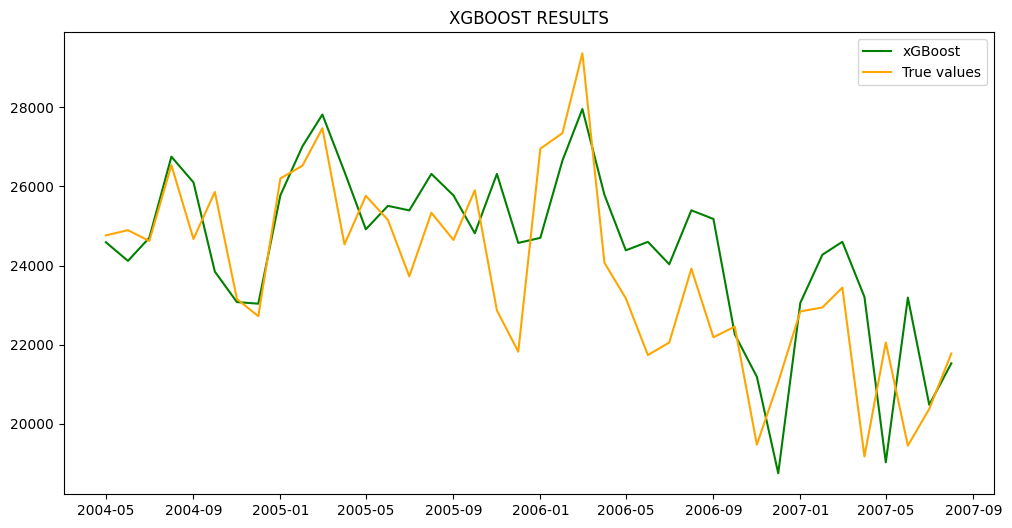

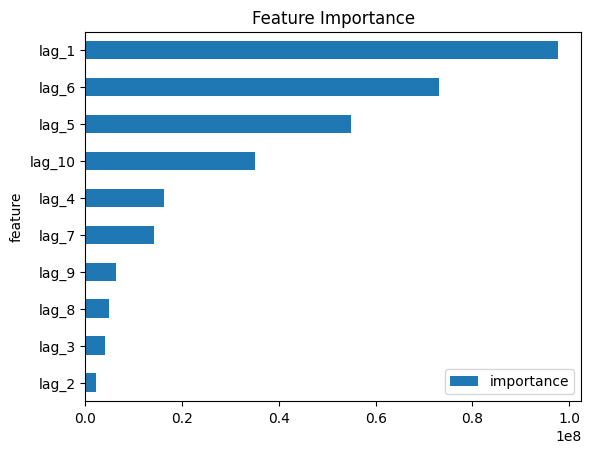

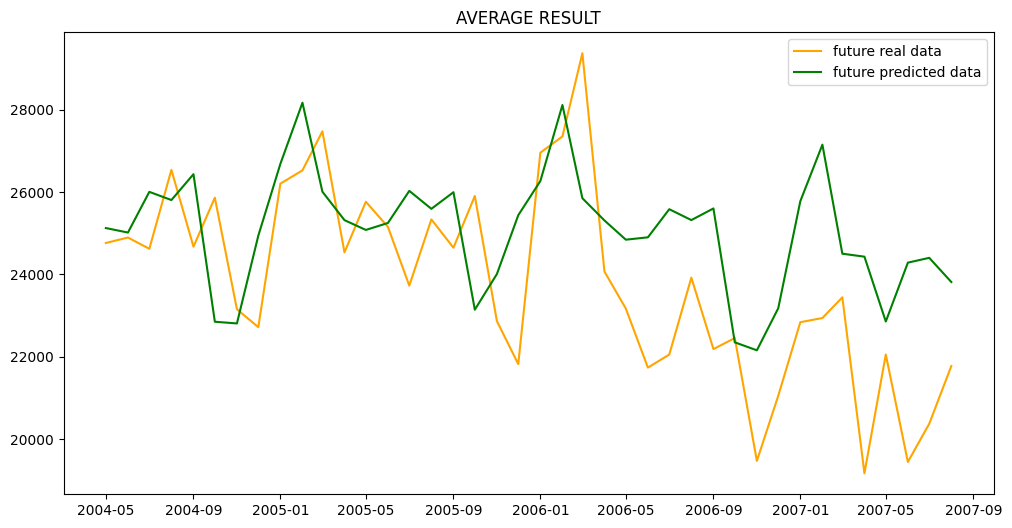

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 2345.35665428332}


In [ ]:
rmse_dict = {}
forcast_dict = {}


'''
RUN IF YOU WANT 2004 - > 2008 (validation)
NOTE

the following function calculates the predicted values
from the validation set not the test set as well as the RMSE

'''
data_original = df
Arima_parameters = Arima_parameters
xGboost_parameters = xGboost_parameters

"""
parameters :
data: Pandas dataframe of a single series with index of type DateTime
Arima_parameters: Tuple -or list like- of shape (3) with P,Q,D
xGboost_parameters: a list of 2 items
  - the fist is a dictionary with the parameters
  - the second is the number of iterations
"""

# part 1 | ARIMA
data_A = data_original.copy()
# split the data
train = data_A[:220]
test = data_A[220:260]


# build the model
model = ARIMA(train, order = Arima_parameters)
model_fit = model.fit()


# evaluate the ARIMA model in the test set
forecast_df = model_fit.predict(start = 221, end = 260 )
forecast = np.array(forecast_df)

forcast_dict['ARIMA'] = forecast
rmse = sqrt(mean_squared_error(test, forecast))
rmse_dict['ARIMA'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
'''
plt.fill_between(
  test.index,
  conf[:,0],
  conf[:,1],
  forecast['Upper'],
  alpha=0.7,
  color='gray',
  label='Confidence Area'
  )
'''
plt.plot(forecast_df, color = 'green', label = "future predicted data")
plt.title("ARIMA RESULTS")
plt.legend()
plt.show()
print(f'model AIC : {model_fit.aic}')
print(f'model BIC : {model_fit.bic}')

# part 2 | xGboost
data = data_original.copy()
# Create multible features (lagged variables)
lags = 10
for i in range(1, lags + 1):
    data[f'lag_{i}'] = data['Total'].shift(i)

# Prepare the data for XGBoost
# split the data into (train, validate, test)

X_train = data[:220].drop(['Total'], axis=1)
y_train = data[:220]['Total']

X_val = data[220:260].drop(['Total'], axis=1)
y_val = data[220:260]['Total']

X_test = data[260:].drop(['Total'], axis=1)
y_test = data[260:]['Total']

# put the data into a form of a matrix that fits into xGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = xGboost_parameters[0]
num_rounds = xGboost_parameters[1]

model = xgb.train(
  params=params,
  dtrain = dtrain,
  num_boost_round=num_rounds,
  early_stopping_rounds=10,
  evals=[(dval, 'validation')]
)

# Evaluate the XGBoost model on the test set
y_pred = model.predict(dval)
forcast_dict['XGBOOST'] = y_pred
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
rmse_dict['XGBOOST'] = rmse

# plot the results
fig = plt.figure(figsize = (12,6))
plt.plot(data[220:260].index,y_pred, color = 'green', label = 'xGBoost')
plt.plot(data[220:260].index,y_val.values, color = 'orange', label = 'True values')
plt.title("XGBOOST RESULTS")
plt.legend()
plt.plot()

#importance of features in XGBOOST
importance = model.get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
fi = pd.DataFrame(importance, columns=['feature', 'importance'])
fi.sort_values('importance').plot(kind='barh', x='feature', y='importance', title='Feature Importance')
plt.show()


# part 3 : the average forcast
# combine the predictions using a weighted average
weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=weights)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT")
plt.legend()
plt.show()

print(rmse_dict)

In [ ]:
weights =[(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]

'''
updated_weights : the weights multiplied by a constant propotional term
this doesnt work cuz in the average mean we devide by the same term

updated_weights_v2 : the weights multiplied by a biased term
the biased term is 1 in case of ARIMA
and 2 in case of xGboost

 -- might look effiencent but we cant just multiply by 2 :(
 --- REASONABL solution, use n

updated_weights_v3 : the weights multiplied by a biased term
the biased term is 1 in case of ARIMA
and n in case of xGboost
n is how better xGBoost than arime
n = xGBOOST reult  / ARIMA result
result = 1 / rmse

updated_weights_v4 : the weights to the power of 2
the power helps magnify the larger number

  - THE RIGHT WAY :))
updated_weights_v5 : switch the weights *simply* :))
updated_weights_v6 : switch the weights and power 2
601 tells us that you either switch them or inverse them
HOW GOOD THE MODEL IS : the inverse of how bad the model is
OR how bad the other model is
updated_weights_v7 : switch the weights use bias n

'''

updated_weights = [item * 10 for item in weights]
print(updated_weights)

updated_weights_v2 =[]
for i in range(len(weights)):
  updated_weights_v2.append(weights[i] * (i+1))
print(updated_weights_v2)


updated_weights_v3 =[]
n = rmse_dict['ARIMA'] / rmse_dict['XGBOOST']

for i in range(len(weights)):
  if i == 0:
    updated_weights_v3.append(weights[i])
  elif i == 1:
    updated_weights_v3.append(weights[i] * n)

print(updated_weights_v3)



updated_weights_v4 =[]
for i in range(len(weights)):
  updated_weights_v4.append(weights[i] **2)
print(updated_weights_v4)


updated_weights_v5 =[weights[1], weights[0]]
print(updated_weights_v5)



updated_weights_v6 =[weights[1] ** 2, weights[0]**2]
print(updated_weights_v6)


updated_weights_v601 =[weights[0] ** -2, weights[1]** -2]
print(updated_weights_v601)


updated_weights_v7 =[weights[1] * n, weights[0]*n]
print(updated_weights_v7)



[8.180177458534695, 1.8198225414653058]
[0.8180177458534695, 0.36396450829306115]
[0.8180177458534695, 0.8180177458534695]
[0.6691530325311915, 0.033117540824252445]
[0.18198225414653058, 0.8180177458534695]
[0.033117540824252445, 0.6691530325311915]
[1.494426463580865, 30.195478743629593]
[0.8180177458534695, 3.6770235409458945]


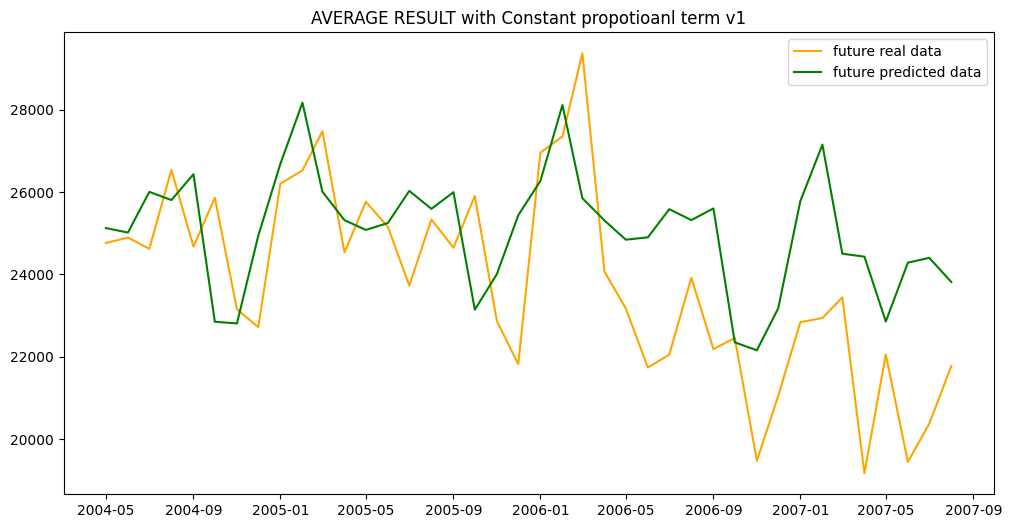

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 2345.356654283321}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with Constant propotioanl term v1")
plt.legend()
plt.show()

print(rmse_dict)

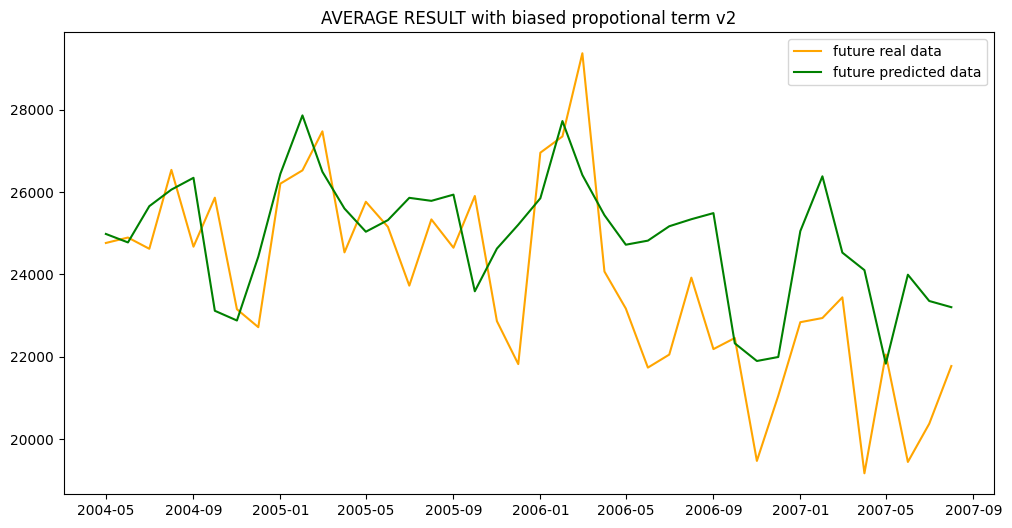

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 2076.413607437277}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights_v2)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with biased propotional term v2")
plt.legend()
plt.show()

print(rmse_dict)

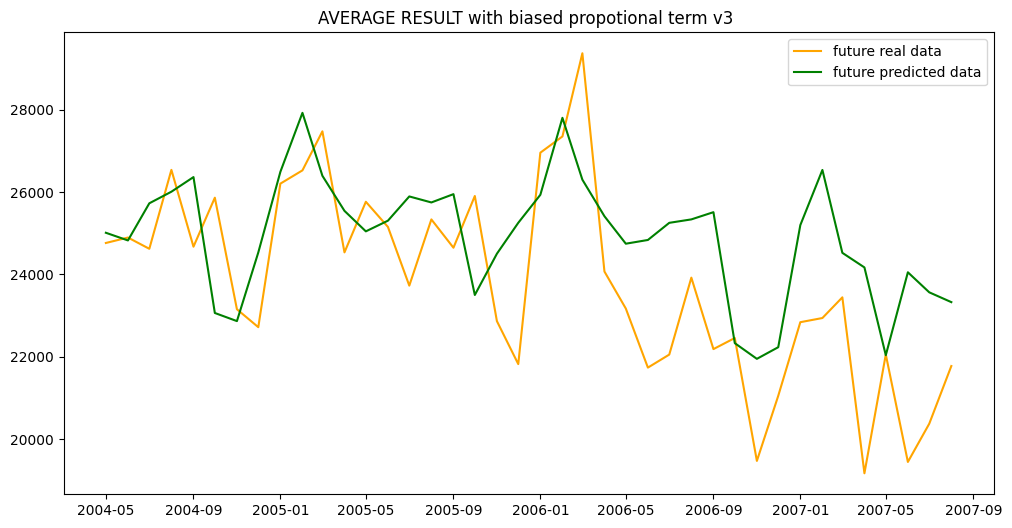

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 2125.6909347451287}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights_v3)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with biased propotional term v3 ")
plt.legend()
plt.show()

print(rmse_dict)

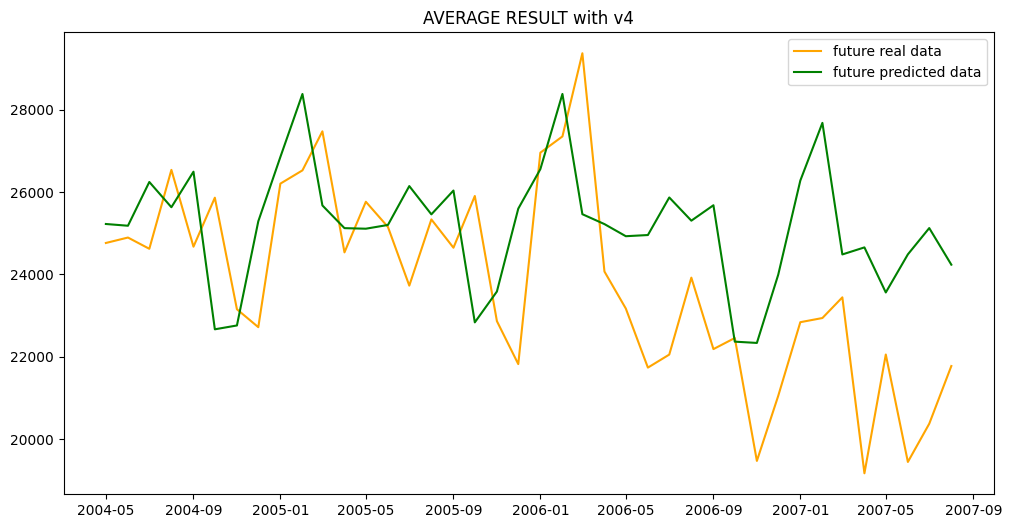

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 2559.6405622986817}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights_v4)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with v4")
plt.legend()
plt.show()

print(rmse_dict)

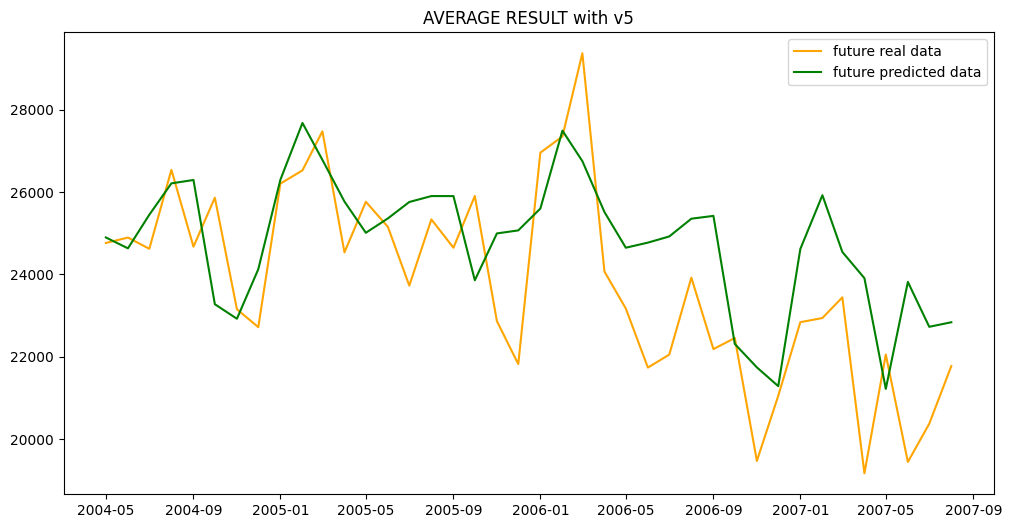

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 1946.7227168743568}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
#weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights_v5)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with v5")
plt.legend()
plt.show()

print(rmse_dict)

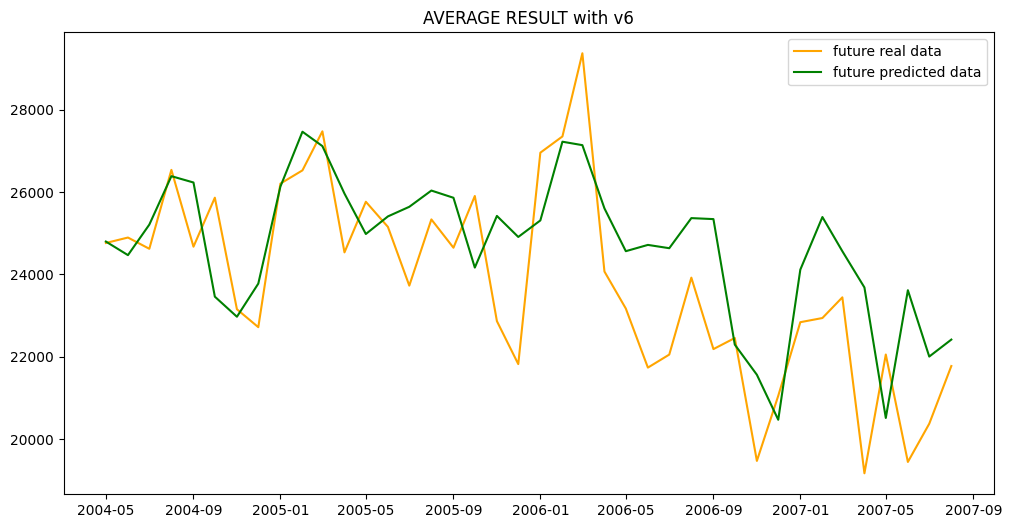

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 1834.2344719088435}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights_v6)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with v6")
plt.legend()
plt.show()

print(rmse_dict)

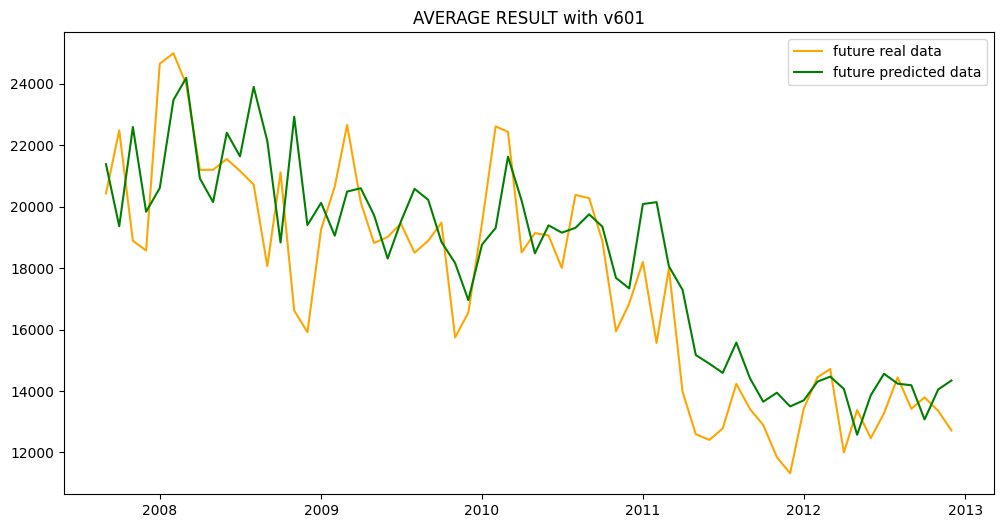

{'ARIMA': 8575.862355485093, 'XGBOOST': 1907.849518684049, 'AVERAGE RESULTS': 1983.3626893255503}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights_v601)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with v601")
plt.legend()
plt.show()

print(rmse_dict)

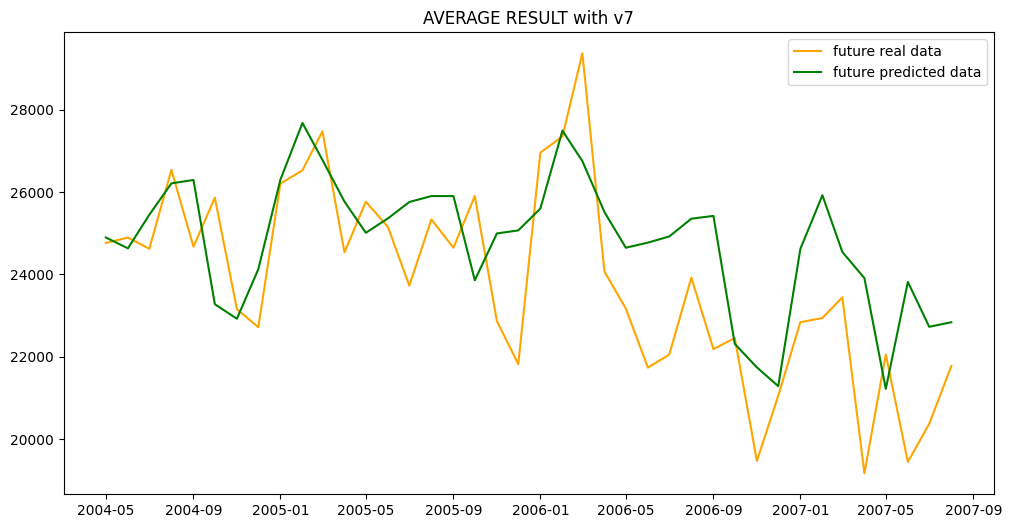

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 1946.7227168743577}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights_v7)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with v7")
plt.legend()
plt.show()

print(rmse_dict)

NOTE for us
after further thinking, the weights has to be of power(-1)
because the model has to be multiplied by how good it is.
and how good is the inverse of how bad...

up to the power of 2 magnifies the larger weight (how goot it is)



AFTER EXPERIMENTING DIFFERENT WEIGHTS
v601

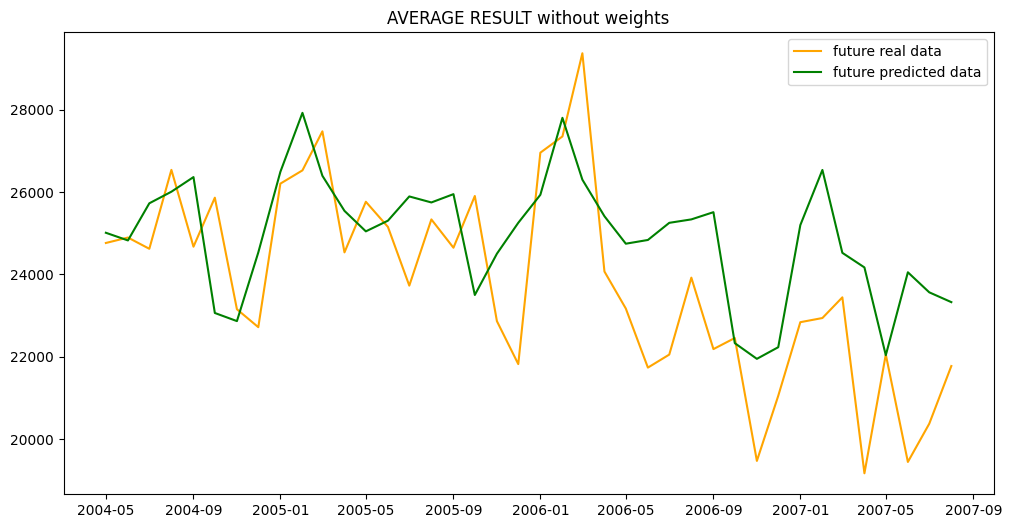

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 2125.6909347451283}


In [ ]:
'''final try without weight'''
weights = [1,1]

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=weights)
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT without weights")
plt.legend()
plt.show()

print(rmse_dict)



**YET , the best result is with v6**

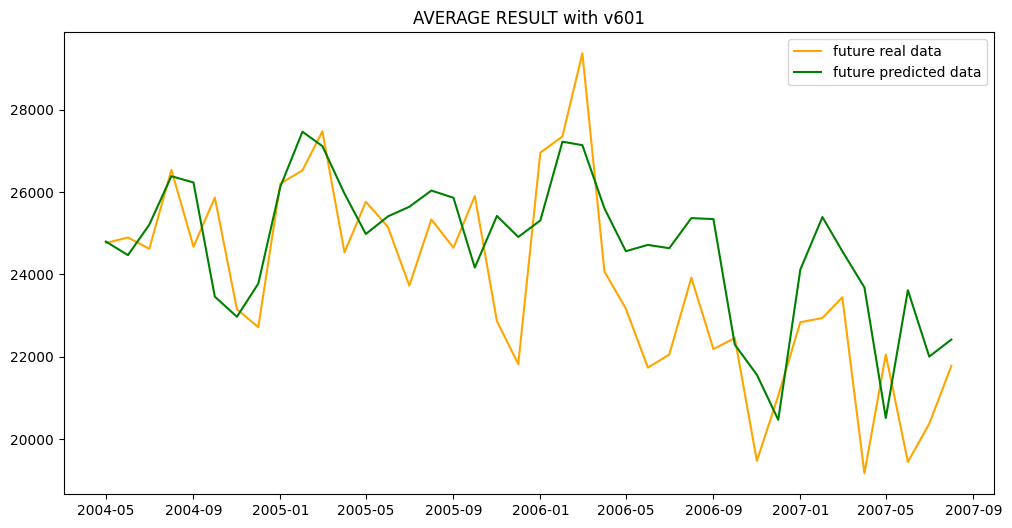

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 1834.234471908843}


In [ ]:

# part 3 : the average forcast
# combine the predictions using a weighted average
# weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=updated_weights_v601)
forcast_dict['AVERAGE MODEL'] = combined_pred
combined_pred = pd.DataFrame(combined_pred, index = test.index)
rmse = sqrt(mean_squared_error(test.values, combined_pred))
rmse_dict['AVERAGE RESULTS'] = rmse


# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with v601")
plt.legend()
plt.show()

print(rmse_dict)

In [ ]:
'''
the accumilative meta model
this model is built upon all the previous ones

ALGO's discreptoin

FIRST WE NEED to make some modifications:
1- make the weights dependent on the average model results
2- make the result dependent on the average model results
NOW it's no longer a dependent model, it's a meta model (it doesnt work unless you build the base of it which is the avergae model of 601)

now...
FIRST PERIOD: calculate the average results with the normal weights
SECOND PERIOD: calculate the average with weights of the previous period
THIRD PERIOD: calculate the average with weights of the previous period
FORTH PERIOD: calculate the averga with weights of the previod period

'''
results = []
n = 4
#print(updated_weights_v601)
for i in range(0, n*10 , 10):
  weights = [(rmse_dict['ARIMA']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'] + rmse_dict['AVERAGE RESULTS']),
            (rmse_dict['XGBOOST']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'] + rmse_dict['AVERAGE RESULTS']),
            (rmse_dict['AVERAGE RESULTS']) / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'] + rmse_dict['AVERAGE RESULTS'])]
  updated_weights_v601_in =[weights[0] ** -2, weights[1]**-2, weights[2]**-2]
  print(updated_weights_v601_in)

  combined_pred = np.average([forcast_dict['ARIMA'][i:i+10], forcast_dict['XGBOOST'][i:i+10], forcast_dict['AVERAGE MODEL'][i:i+10]], axis=0, weights=updated_weights_v601_in)
  results.append(combined_pred)
  combined_pred = pd.DataFrame(combined_pred, index = test[i:i+10].index)
  rmse = sqrt(mean_squared_error(test[i:i+10].values, combined_pred))
  rmse_dict['AVERAGE RESULTS'] = rmse

rmse_dict

'''
shof men el model el kwys w edelo weight a3la
'''

[5.523917345470937, 16.812727318065807, 9.147220521742437]
[3.655698105504817, 11.126570432016909, 31.84993887953224]
[4.470678274976369, 13.607063622269036, 15.263626486481646]
[4.938222497664352, 15.030092432002231, 11.723663329729469]


{'ARIMA': 3064.7449572228384,
 'XGBOOST': 1756.705011580363,
 'AVERAGE RESULTS': 2381.624834651756}

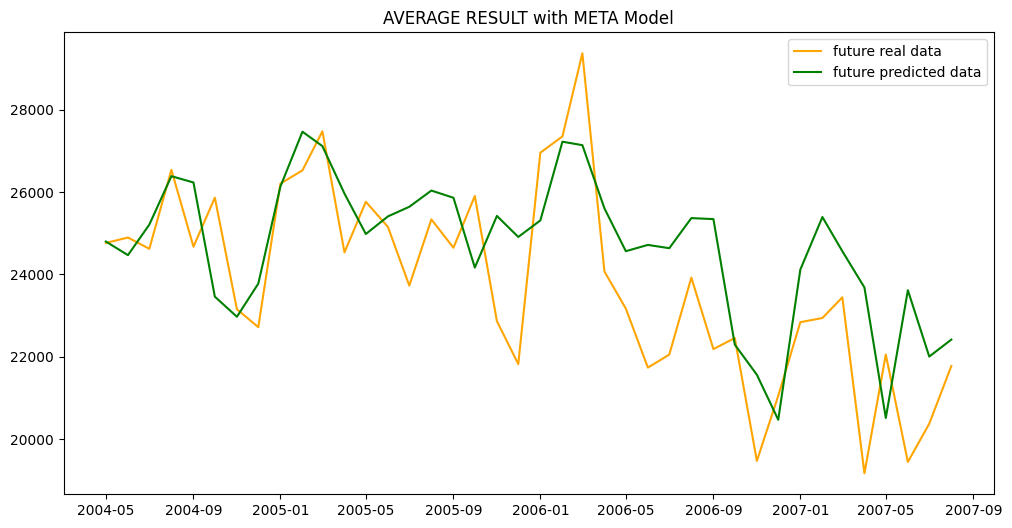

{'ARIMA': 3064.7449572228384, 'XGBOOST': 1756.705011580363, 'AVERAGE RESULTS': 2381.624834651756}


In [ ]:

# plot the result
fig = plt.figure(figsize = (12,6))
plt.plot(test, color = 'orange', label = "future real data")
combined_pred = pd.DataFrame(np.array(results).reshape(40,), index = test.index)
plt.plot(combined_pred, color = 'green', label = "future predicted data")
plt.title("AVERAGE RESULT with META Model")
plt.legend()
plt.show()

print(rmse_dict)